### Installations and Imports

In [1]:
!pip install ucimlrepo
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 4.4 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import pandas as pd

import ucimlrepo

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BinaryLabelDataset

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Data Exploration and Preprocessing

In [3]:
# fetch dataset
adult = ucimlrepo.fetch_ucirepo(id=2)

df = adult.data.features
y = adult.data.targets
df = df.join(y)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Handling null values in the data. Some null values are identified by `'?'` which we need to change.

In [5]:
df[df == '?'] = np.nan
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education-num   45222 non-null  int64 
 5   marital-status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital-gain    45222 non-null  int64 
 11  capital-loss    45222 non-null  int64 
 12  hours-per-week  45222 non-null  int64 
 13  native-country  45222 non-null  object
 14  income          45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [6]:
df['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],'Non-White', inplace = True)

df = df.replace({"<=50K.":"<=50K", ">50K.":">50K"})
df['income']=df['income'].map({'<=50K': 0, '>50K': 1})
df.drop(['education'], axis = 1, inplace = True)

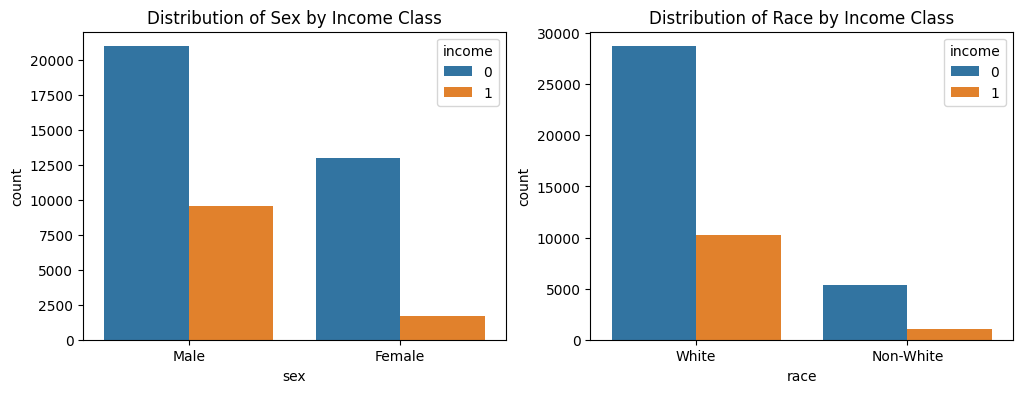

In [ ]:
# @title
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot distribution of sex by income class
sns.countplot(x='sex', hue='income', data=df, ax=axes[0])
axes[0].set_title('Distribution of Sex by Income Class')

# Plot distribution of race by income class
sns.countplot(x='race', hue='income', data=df, ax=axes[1])
axes[1].set_title('Distribution of Race by Income Class')

plt.show()


In [ ]:
# @title
# Number of columns in the dataframe excluding the 'income' column
num_columns = len(df.columns) - 1

# Number of rows and columns for the subplots
num_rows = (num_columns + 2) // 3  # Add 2 to ensure that there are enough rows for all subplots
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over the columns and plot each one in a separate subplot
for i, column in enumerate(df.columns[:-1]):  # Exclude the 'income' column
    ax = axes[i]
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue='income', data=df, ax=ax)
    else:
        sns.histplot(df, x=column, hue='income', bins=20, kde=True, stat='density', ax=ax)
    ax.set_title(f"Distribution of {column} by Income Class")
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


In [7]:
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['race'] = df['race'].map({'White': 1, 'Non-White': 0})

one-hot encoding the categorical variables

In [8]:
df_encoded = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns)
df_encoded.head()

,age,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,1,1,2174,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,1,0,0,13,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,1,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,1,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0


**Development Set Splits and Scaling**

Split Data into Training (70%), Validation (15%), Test (15%) stratified based on **sex, race, and income** to maintain the proportions in the original dataset.

In [9]:
# Split the combined DataFrame into train and test sets, stratifying on sex and race
df_train, df_test = train_test_split(df_encoded, test_size=0.3, stratify=df_encoded[['sex', 'race','income']], random_state=42)

# Split the train set into train and validation sets, stratifying on sex and race
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test[['sex', 'race','income']], random_state=42)


### Exploring Biases in the Data

The sensitive attributes in this dataset are race and sex. **For this tutorial, we focus on the biases against sex.**

According to the distribution of incomes for females and males:
*   Privileged group: Males
*   Unprivileged group: Females



We are using **AIF360** library for exploring biases.

We need to convert dataframes to it's acceptable format `BinaryLabelDataset`.

In [10]:
# Define the name of the target label column
label_name = 'income'  # Change this to the name of your label column

# Define the names of the sensitive attribute columns
sensitive_attributes = ['race', 'sex']  # Change this to your sensitive attribute columns

train_bld = BinaryLabelDataset(df=df_train, label_names=[label_name],protected_attribute_names=sensitive_attributes)
valid_bld = BinaryLabelDataset(df=df_val, label_names=[label_name],protected_attribute_names=sensitive_attributes)
test_bld = BinaryLabelDataset(df=df_test, label_names=[label_name],protected_attribute_names=sensitive_attributes)

Fairness can be evaluated in different stages of machine learning pipeline, either on the training data or on the learned model.

Here we look at the difference in mean outcomes difference/ Statistical Parity Difference between unprivileged and privileged groups (females vs males).

Statistical Parity Difference (SPD) is defined as:

$$
\text{SPD} = P(\hat{Y} = 1 | D = \text{unprivileged}) - P(\hat{Y} = 1 | D = \text{privileged})
$$
where:

- $\hat{Y} = 1$ indicates a positive outcome (e.g., having >50k income).
- $D = \text{unprivileged}$ indicates membership in the unprivileged group.
- $D = \text{privileged}$ indicates membership in the privileged group.

Ideal value for $SPD$ is zero. $SPD < 0$ indicates that unprivileged group has a lower rate of positive outcomes.

For metrics on Data we use `BinaryLabelDatasetMetric`.

In [11]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

DM_train_org = BinaryLabelDatasetMetric(train_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Train Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_train_org.mean_difference())


DM_valid_org = BinaryLabelDatasetMetric(valid_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Valid Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_valid_org.mean_difference())


DM_test_org = BinaryLabelDatasetMetric(test_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_test_org.mean_difference())

Train Set: Difference in mean outcomes between unprivileged and privileged groups = -0.198935
Valid Set: Difference in mean outcomes between unprivileged and privileged groups = -0.199015
Test Set: Difference in mean outcomes between unprivileged and privileged groups = -0.198630


The $SPD$ results suggest that the unprivileged group has consistently lower rate of positive incomes in all sets.

## Fairness Evaluation
### Choose Appropriate Fairness Metrics:
Define what fairness means in the context of predicting income levels.

* Does it mean that men and women should be classified as earning more than $50K at equal rates when they actually do (equality of opportunity)?
* Should the overall rates of prediction be equal regardless of the base rates (demographic parity)?

> *Other consideration in real-world*: Legal and ethical considerations, different stakeholders perspectives and needs, how bias impacts both unprivileged and privileged groups?




***If a woman and a man have the same qualifications and contribute similarly to their roles, it is fair for a model to predict their income levels similarly.***

#### **Equality of Opportunity:**
 ideal value is zero. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness range for this metric is $[-0.1, 0.1]$.


$${TPR}_{D = unprivileged} - {TPR}_{D = privileged}$$
<!-- $$ TPR = \frac{TP}{P} $$ -->


#### **Average Odds Difference**:
 ideally zero. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness range for this metric is $[-0.1, 0.1]$.

$$ \frac{1}{2}[({FPR}_{D = unprivileged} - {FPR}_{D = privileged}) + ({TPR}_{D = unprivileged} - {TPR}_{D = privileged})]$$

#### **Balanced Accuracy**:

$$
\frac{{TPR} + {TNR}}{2}
$$

##Train initial model with original data



In [12]:
import torch

import torch # pytorch main library
import torchvision # computer vision utilities
import torchvision.transforms as transforms # transforms used in the pre-processing of the data

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

####Using MinMaxScaler to trasnform data into [0,1] range.



In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_bld.features)
y_train = train_bld.labels.ravel()

X_val = scaler.transform(valid_bld.features)
y_val = valid_bld.labels.ravel()

X_test = scaler.transform(test_bld.features)
y_test = test_bld.labels.ravel()

In [14]:
# Print the shapes of the train, validation, and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (31655, 83), y_train shape: (31655,)
X_val shape: (6784, 83), y_val shape: (6784,)
X_test shape: (6783, 83), y_test shape: (6783,)


In [15]:
class IncomeDataset(Dataset):
    def __init__(self, features, labels, weights = None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.weights is not None:
            return self.features[idx], self.labels[idx], self.weights[idx]
        return self.features[idx], self.labels[idx]


def load_data(X_train, y_train, X_val, y_val, X_test, y_test, w_train = None, batch = 500):
    # Create dataset instances
    train_dataset = IncomeDataset(X_train, y_train, w_train)
    val_dataset = IncomeDataset(X_val, y_val)
    test_dataset = IncomeDataset(X_test, y_test)

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, val_loader, test_loader

Define Fully Connected Network.

In [16]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

Training Loop

In [ ]:
def training(model, train_loader, val_loader, epoch, optimizer, scheduler, model_path, reweigh = False):

    criterion = nn.BCELoss(reduction='none')

    best_val_loss = 100000000
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, labels = data[:2]
            optimizer.zero_grad()
            outputs = model(inputs)

            if reweigh:
                weights = data[2]
                loss = (criterion(outputs.squeeze(), labels.float()) * weights).mean()
            else:
                loss = criterion(outputs.squeeze(), labels.float()).mean()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float()).mean()
                val_loss += loss.item()


        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), baseline_model_path)

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, LR: {optimizer.param_groups[0]['lr']}")

    return train_losses, val_losses

Train Baseline Model using original data (no bias mitigation)

In [ ]:
baseline_model_path = 'baseline_model_path.pth'

input_size = X_train.shape[1]
model_baseline = Net(input_size)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
num_epochs = 10

train_loader_org, val_loader_org, test_loader_org = load_data(X_train, y_train, X_val, y_val, X_test, y_test)

train_losses_org, val_losses_org = training(model_baseline, train_loader_org, val_loader_org, num_epochs, optimizer, scheduler, baseline_model_path)

Epoch 1/10 - Train Loss: 0.00113, Val Loss: 0.00088, LR: 0.001
Epoch 2/10 - Train Loss: 0.00081, Val Loss: 0.00079, LR: 0.001
Epoch 3/10 - Train Loss: 0.00075, Val Loss: 0.00074, LR: 0.001
Epoch 4/10 - Train Loss: 0.00071, Val Loss: 0.00071, LR: 0.001
Epoch 5/10 - Train Loss: 0.00069, Val Loss: 0.00069, LR: 0.001
Epoch 6/10 - Train Loss: 0.00067, Val Loss: 0.00068, LR: 0.001
Epoch 7/10 - Train Loss: 0.00066, Val Loss: 0.00068, LR: 0.001
Epoch 8/10 - Train Loss: 0.00066, Val Loss: 0.00067, LR: 0.001
Epoch 9/10 - Train Loss: 0.00065, Val Loss: 0.00067, LR: 0.001
Epoch 10/10 - Train Loss: 0.00064, Val Loss: 0.00067, LR: 0.001


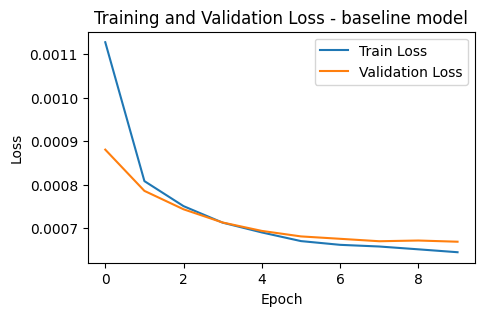

In [ ]:
# @title
# Create the plot
plt.figure(figsize=(5,3))
plt.plot(train_losses_org, label='Train Loss')
plt.plot(val_losses_org, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - baseline model')

# Add legend and show the plot
plt.legend()
plt.show()


Getting Validation and Test probabilities using the baseline model and saving them in `BinaryLabelDataset` objects.

In [ ]:
def predict_prob(model, val_loader, val_data, test_loader, test_data, model_path):
    model.load_state_dict(torch.load(baseline_model_path))
    model.eval()

    val_probs = []
    test_probs = []

    with torch.no_grad():
        for inputs, label in val_loader_org:
            outputs = model(inputs)
            val_probs.extend(outputs.squeeze().cpu().numpy())

        for inputs, label in test_loader_org:
            outputs = model(inputs)
            test_probs.append(outputs.squeeze().cpu().numpy())


    valid_pred = val_data.copy(deepcopy=True)
    test_pred = test_data.copy(deepcopy=True)

    valid_pred.scores = np.array(val_probs).reshape(-1, 1)
    test_pred.scores = np.array(test_probs).reshape(-1, 1)

    return valid_pred, test_pred

In [ ]:
valid_bld_pred, test_bld_pred = predict_prob(model_baseline, val_loader_org, valid_bld, test_loader_org, test_bld, baseline_model_path)

Find the optimal classification threshold from the validation set

In [ ]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):

    valid_bld_pred.labels = (valid_bld_pred.scores >= class_thresh).astype(int)

    classified_metric_orig_valid = ClassificationMetric(valid_bld,
                                             valid_bld_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.8271
Optimal classification threshold (no reweighing) = 0.3070


Evaluate results on test set for each threshold.

In [ ]:
test_metrics = {
    'balanced accuracy': [],
    'equal opportunity diff': [],
    'avg odds diff':[]
}

print("Classification threshold used = %.4f" % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    test_bld_pred.labels = (test_bld_pred.scores >= thresh).astype(int)

    metric_test_org = ClassificationMetric(test_bld, test_bld_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

    bal_acc = 0.5*(metric_test_org.true_positive_rate()\
                       +metric_test_org.true_negative_rate())
    eq_opp_diff = metric_test_org.equal_opportunity_difference()
    avg_odd_diff = metric_test_org.average_odds_difference()

    if thresh == best_class_thresh:
        print("\nMetrics using the optimal classification threshold on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    test_metrics['balanced accuracy'].append(bal_acc)
    test_metrics['equal opportunity diff'].append(metric_test_org.equal_opportunity_difference())
    test_metrics['avg odds diff'].append(metric_test_org.average_odds_difference())

Classification threshold used = 0.3070


 52%|█████▏    | 52/100 [00:00<00:00, 164.58it/s]


Metrics using the optimal classification threshold on Test set
Balanced Accuracy: 0.8145423794872704
Equal Opportunity difference: -0.192874901512051
Average Odds difference: -0.202611137866918


100%|██████████| 100/100 [00:00<00:00, 166.58it/s]


Text(0.5, 1.0, 'Test Set Evaluation')

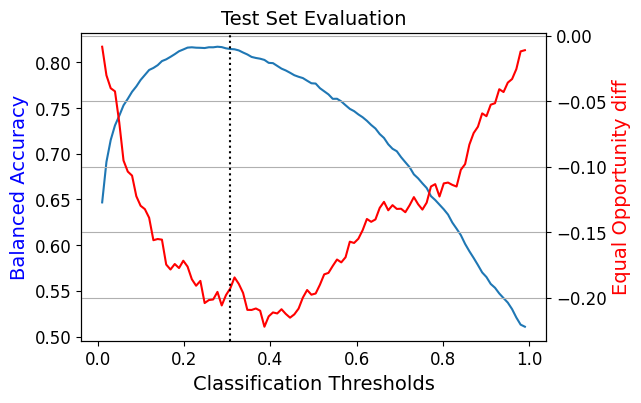

In [ ]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics['equal opportunity diff'] , color='r')
ax2.set_ylabel('Equal Opportunity diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation", fontsize=14)

Text(0.5, 1.0, 'Test Set Evaluation')

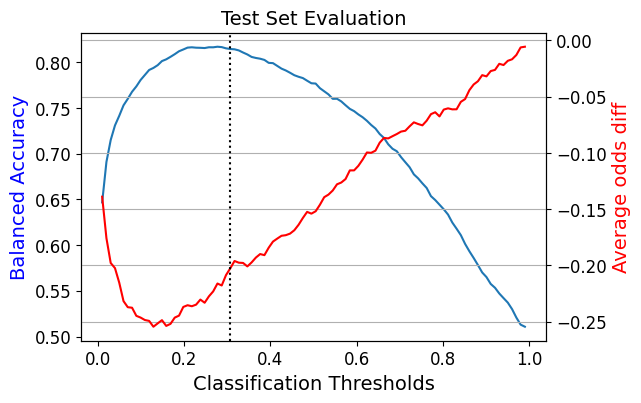

In [ ]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics['avg odds diff'] , color='r')
ax2.set_ylabel('Average odds diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation", fontsize=14)

###  Choose Bias Mitigation Technique:
* Pre-processing: Modify the training data to remove biases before model
training (e.g., reweighing, sampling).
* In-processing: Modify the learning algorithm to reduce bias during model training (e.g., adversarial debiasing).
* Post-processing: Adjust the model’s predictions to reduce bias after training (e.g., equalized odds post-processing).


#### **Calibrated equal odds post-processing**:
This technique has to aims:
1. **Equal Odds**: The model should have similar accuracy for both positive and negative classes across privileged and unprivileged groups. This means equalizing the false positive rates (FPR) and true positive rates (TPR) across these groups.

2. **Calibration**: The predicted probabilities should accurately reflect the true likelihood of the positive class. For example, if a model predicts a probability of 0.7, then approximately 70% of those predictions should be correct.

### 1. Preprocessing: Reweighing

Weights the examples in each (group, label) combination differently to ensure fairness before classification.

- Overall positive class probability: $(P(Y=1))$.
- Positive class probability for each group: $(P(Y=1|G=\text{group}))$.

- For each sample in a group:
    - Positive class weight: $(\frac{P(Y=1)}{P(Y=1|G=\text{group})})$.

    - Negative class weight: $(\frac{1 - P(Y=1)}{1 - P(Y=1|G=\text{group})})$.



In [ ]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

# Reweigh trian samples
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train_bld)
train_bld_rw = RW.transform(train_bld)

# Fit scaler to reweighted train set
scale_rw = MinMaxScaler()
X_train_rw = scale_rw.fit_transform(train_bld_rw.features)
y_train_rw = train_bld_rw.labels.ravel()
w_train_rw = train_bld_rw.instance_weights.ravel()

# Scale validation and test set using new scaler
X_val_rw = scale_rw.transform(valid_bld.features)

X_test_rw = scale_rw.transform(test_bld.features)

Train model using reweighed data.

In [ ]:
RW_model_path = 'rw_model_path.pth'
# Set up the loss function and optimizer
model = Net(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
num_epochs = 10

train_loader_rw, val_loader_rw, test_loader_rw = load_data(X_train_rw, y_train_rw, X_val_rw, y_val, X_test_rw, y_test, w_train_rw)

train_losses_rw, val_losses_rw = training(model, train_loader_rw, val_loader_rw, num_epochs, optimizer, scheduler, RW_model_path, reweigh=True)

Epoch 1/10 - Train Loss: 0.00111, Val Loss: 0.00086, LR: 0.001
Epoch 2/10 - Train Loss: 0.00080, Val Loss: 0.00079, LR: 0.001
Epoch 3/10 - Train Loss: 0.00075, Val Loss: 0.00077, LR: 0.001
Epoch 4/10 - Train Loss: 0.00072, Val Loss: 0.00075, LR: 0.001
Epoch 5/10 - Train Loss: 0.00070, Val Loss: 0.00072, LR: 0.001
Epoch 6/10 - Train Loss: 0.00068, Val Loss: 0.00071, LR: 0.001
Epoch 7/10 - Train Loss: 0.00067, Val Loss: 0.00070, LR: 0.001
Epoch 8/10 - Train Loss: 0.00066, Val Loss: 0.00071, LR: 0.001
Epoch 9/10 - Train Loss: 0.00066, Val Loss: 0.00069, LR: 0.001
Epoch 10/10 - Train Loss: 0.00066, Val Loss: 0.00068, LR: 0.001


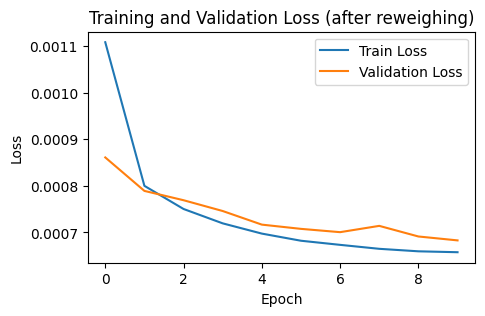

In [ ]:
# @title
# Create the plot
plt.figure(figsize=(5,3))
plt.plot(train_losses_rw, label='Train Loss')
plt.plot(val_losses_rw, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (after reweighing)')

# Add legend and show the plot
plt.legend()
plt.show()

Getting Validation and Test probabilities using the reweighed model.

In [ ]:
valid_pred_rw, test_pred_rw = predict_prob(val_loader_rw, valid_bld, test_loader_rw, test_bld, RW_model_path)

Find new optimal threshold using validation set for reweigh model.

In [ ]:
num_thresh = 100
ba_arr_rw = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):

    valid_pred_rw.labels = (valid_pred_rw.scores >= class_thresh).astype(int)

    classified_metric_orig_valid = ClassificationMetric(valid_bld,
                                             valid_pred_rw,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr_rw[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind_rw = np.where(ba_arr_rw == np.max(ba_arr_rw))[0][0]
best_class_thresh_rw = class_thresh_arr[best_ind_rw]

print("Best balanced accuracy (reweighing) = %.4f" % np.max(ba_arr_rw))
print("Optimal classification threshold (reweighing) = %.4f" % best_class_thresh_rw)

Best balanced accuracy (reweighing) = 0.8185
Optimal classification threshold (reweighing) = 0.2377


Evaluation results of test set using reweigh model on different threshold.

In [ ]:
test_metrics_rw = {
    'balanced accuracy': [],
    'equal opportunity diff': [],
    'avg odds diff':[]
}

print("Classification threshold used = %.4f" % best_class_thresh_rw)

for thresh in tqdm(class_thresh_arr):
    test_pred_rw.labels = (test_pred_rw.scores >= thresh).astype(int)

    metric_test_rw = ClassificationMetric(test_bld, test_pred_rw,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

    bal_acc = 0.5*(metric_test_rw.true_positive_rate()\
                       +metric_test_rw.true_negative_rate())
    eq_opp_diff = metric_test_rw.equal_opportunity_difference()
    avg_odd_diff = metric_test_rw.average_odds_difference()

    if thresh == best_class_thresh_rw:
        print("\nMetrics using the optimal classification threshold on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    test_metrics_rw['balanced accuracy'].append(bal_acc)
    test_metrics_rw['equal opportunity diff'].append(metric_test_rw.equal_opportunity_difference())
    test_metrics_rw['avg odds diff'].append(metric_test_rw.average_odds_difference())


Classification threshold used = 0.2377


 14%|█▍        | 14/100 [00:00<00:00, 130.86it/s]


Metrics using the optimal classification threshold on Test set
Balanced Accuracy: 0.8080615794016748
Equal Opportunity difference: -0.033793546986059964
Average Odds difference: -0.0851800356167233


100%|██████████| 100/100 [00:00<00:00, 144.41it/s]


Text(0.5, 1.0, 'Test Set Evaluation (Reweighing)')

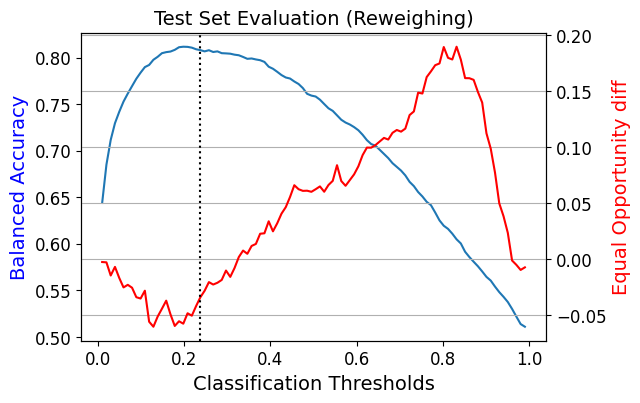

In [ ]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_rw['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_rw['equal opportunity diff'] , color='r')
ax2.set_ylabel('Equal Opportunity diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh_rw, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation (Reweighing)",fontsize=14)

Text(0.5, 1.0, 'Test Set Evaluation (Reweighing)')

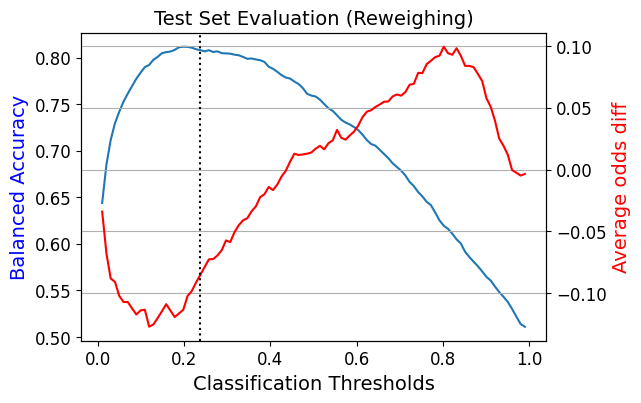

In [ ]:
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_rw['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_rw['avg odds diff'] , color='r')
ax2.set_ylabel('Average odds diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh_rw, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation (Reweighing)",fontsize=14)

### EXTRA (KEEP OR NOT)

In [ ]:
cm_pred_valid = ClassificationMetric(valid_bld, valid_bld_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in Equal Opportunity between unprivileged and privileged groups")
print(cm_pred_valid.equal_opportunity_difference())
print("Difference in Average Odds between unprivileged and privileged groups")
print(cm_pred_valid.average_odds_difference())

cm_pred_test = ClassificationMetric(test_bld, test_bld_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in Equal Opportunity between unprivileged and privileged groups")
print(cm_pred_test.equal_opportunity_difference())
print("Difference in Average Odds between unprivileged and privileged groups")
print(cm_pred_test.average_odds_difference())

#### Original-Predicted validation dataset

Difference in Equal Opportunity between unprivileged and privileged groups
-0.1486904262753319
Difference in Average Odds between unprivileged and privileged groups
-0.11777762966085588


#### Original-Predicted testing dataset

Difference in Equal Opportunity between unprivileged and privileged groups
-0.17845041914800613
Difference in Average Odds between unprivileged and privileged groups
-0.13371017096985516


In [ ]:
import matplotlib.pyplot as plt

def plot_fairness_metric(cm_pred, cm_pred_mitigated=None):
    """
    Plots the equal opportunity difference and average odds difference from the
    classification metric objects in separate subfigures.

    Parameters:
    cm_pred (ClassificationMetric): The classification metric object for the original model.
    cm_pred_mitigated (ClassificationMetric, optional): The classification metric object for the mitigated model.
    """
    # Define the fair range
    fair_range = (-0.1, 0.1)

    # Calculate metrics
    equal_opportunity_diff_original = cm_pred.equal_opportunity_difference()
    average_odds_diff_original = cm_pred.average_odds_difference()

    # Initialize subfigures
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Highlight the fair range for both subfigures
    for ax in axs:
        ax.axhspan(fair_range[0], fair_range[1], color='green', alpha=0.1)
        ax.axhline(y=0, color='black', linewidth=0.8)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(-1, 1)
        ax.set_xticks([])

    # Plot Equal Opportunity Difference
    axs[0].bar(-0.5, equal_opportunity_diff_original, width=0.5, color='gray', edgecolor='black', label='Original')
    axs[0].text(-0.5, equal_opportunity_diff_original*1.8, f'{equal_opportunity_diff_original:.2f}', ha='center', va='bottom')
    axs[0].set_title('Equal Opportunity Difference')

    # Plot Average Odds Difference
    axs[1].bar(-0.5, average_odds_diff_original, width=0.5, color='gray', edgecolor='black', label='Original')
    axs[1].text(-0.5, average_odds_diff_original*1.8, f'{average_odds_diff_original:.2f}', ha='center', va='bottom')
    axs[1].set_title('Average Odds Difference')


    # If a mitigated metric is provided, calculate and plot it
    if cm_pred_mitigated is not None:
        equal_opportunity_diff_mitigated = cm_pred_mitigated.equal_opportunity_difference()
        average_odds_diff_mitigated = cm_pred_mitigated.average_odds_difference()

        axs[0].bar(0.5, equal_opportunity_diff_mitigated, width=0.5, color='orange', edgecolor='black', label='Mitigated')
        axs[0].text(0.5, equal_opportunity_diff_mitigated*1.8, f'{equal_opportunity_diff_mitigated:.2f}', ha='center', va='bottom')

        axs[1].bar(0.5, average_odds_diff_mitigated, width=0.5, color='orange', edgecolor='black', label='Mitigated')
        axs[1].text(0.5, average_odds_diff_mitigated*1.8, f'{average_odds_diff_mitigated:.2f}', ha='center', va='bottom')

    # Add legend
    # handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    # Display the plot
    plt.show()

# Example usage:
# plot_fairness_metric(cm_pred_test, cm_pred_mitigated=cm_pred_test_cpp)


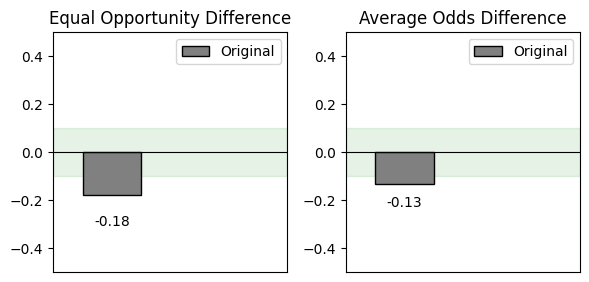

In [ ]:
plot_fairness_metric(cm_pred_test)

### Post-processing: Calibrated Equal Odds Prediction

In [ ]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 42
# Learn parameters to equalize odds and apply to create a new dataset
CEO = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
CEO = CEO.fit(valid_bld, valid_bld_pred)

In [ ]:
valid_pred_ceo = CEO.predict(valid_bld_pred)
test_pred_ceo = CEO.predict(test_bld_pred)

In [ ]:
cm_pred_valid_ceo = ClassificationMetric(valid_bld, valid_pred_ceo,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in Equal Opportunity between unprivileged and privileged groups")
print(cm_pred_valid_cpp.equal_opportunity_difference())
print("Difference in Average Odds between unprivileged and privileged groups")
print(cm_pred_valid_cpp.average_odds_difference())

cm_pred_test_cpp = ClassificationMetric(test_bld, valid_pred_ceo,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in Equal Opportunity between unprivileged and privileged groups")
print(cm_pred_test_cpp.equal_opportunity_difference())
print("Difference in Average Odds between unprivileged and privileged groups")
print(cm_pred_test_cpp.average_odds_difference())

#### Original-Transformed validation dataset

Difference in Equal Opportunity between unprivileged and privileged groups
0.1371236897274633
Difference in Average Odds between unprivileged and privileged groups
0.04577090182418733


#### Original-Transformed testing dataset

Difference in Equal Opportunity between unprivileged and privileged groups
0.08011002809168632
Difference in Average Odds between unprivileged and privileged groups
0.019553534225594638


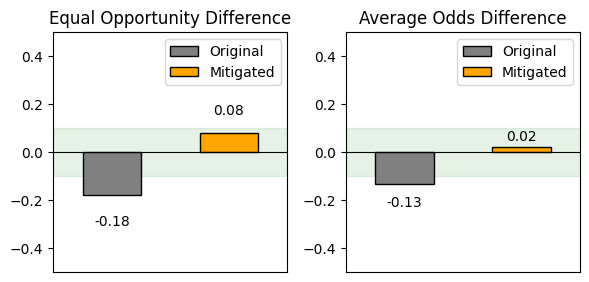

In [ ]:
plot_fairness_metric(cm_pred_test, cm_pred_test_cpp)

In [ ]:
from tqdm import tqdm
# Function to calculate metrics for a range of thresholds
def calculate_metrics_for_thresholds(dataset_orig, dataset_pred, dataset_pred_mitigated, unprivileged_groups, privileged_groups, all_thresh):
    metrics = {
        'bef_tpr_diff': [],
        'aft_tpr_diff': [],
        'bef_bal_acc': [],
        'aft_bal_acc': []
    }

    for thresh in tqdm(all_thresh):
        # Thresholding for the original and mitigated datasets
        dataset_pred_thresh = threshold_dataset(dataset_pred, thresh)
        dataset_pred_mitigated_thresh = threshold_dataset(dataset_pred_mitigated, thresh)

        # Metrics for the original dataset
        classified_metric_orig = ClassificationMetric(dataset_orig, dataset_pred_thresh, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metrics['bef_tpr_diff'].append(classified_metric_orig.average_odds_difference())
        metrics['bef_bal_acc'].append(0.5 * (classified_metric_orig.true_positive_rate() + classified_metric_orig.true_negative_rate()))

        # Metrics for the mitigated dataset
        classified_metric_mitigated = ClassificationMetric(dataset_orig, dataset_pred_mitigated_thresh, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metrics['aft_tpr_diff'].append(classified_metric_mitigated.average_odds_difference())
        metrics['aft_bal_acc'].append(0.5 * (classified_metric_mitigated.true_positive_rate() + classified_metric_mitigated.true_negative_rate()))

    return metrics

# Function to threshold datasets based on a given threshold
def threshold_dataset(dataset_pred, thresh):
    dataset_thresh = dataset_pred.copy(deepcopy=True)
    y_temp = (dataset_thresh.scores >= thresh).astype(int)
    dataset_thresh.labels = y_temp
    return dataset_thresh

# Function to plot metrics
def plot_metrics(metrics, all_thresh, data_name='validation'):

    fig, ax1 = plt.subplots(figsize=(13,7))

    ax1.plot(all_thresh, metrics['bef_bal_acc'], color='b')
    ax1.plot(all_thresh, metrics['aft_bal_acc'], color='b', linestyle='dashed')
    ax1.set_title(f'Original and Postprocessed {data_name} data', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(all_thresh, np.abs(metrics['bef_tpr_diff']), color='r')
    ax2.plot(all_thresh, np.abs(metrics['aft_tpr_diff']), color='r', linestyle='dashed')
    ax2.set_ylabel('abs(Average odds diff)', color='r', fontsize=16, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
                "Avg. odds diff. - Orig.","Avg. odds diff. - Postproc.",],
            fontsize=16)
    plt.tight_layout()
    plt.show()
# Example usage


100%|██████████| 25/25 [00:00<00:00, 29.86it/s]


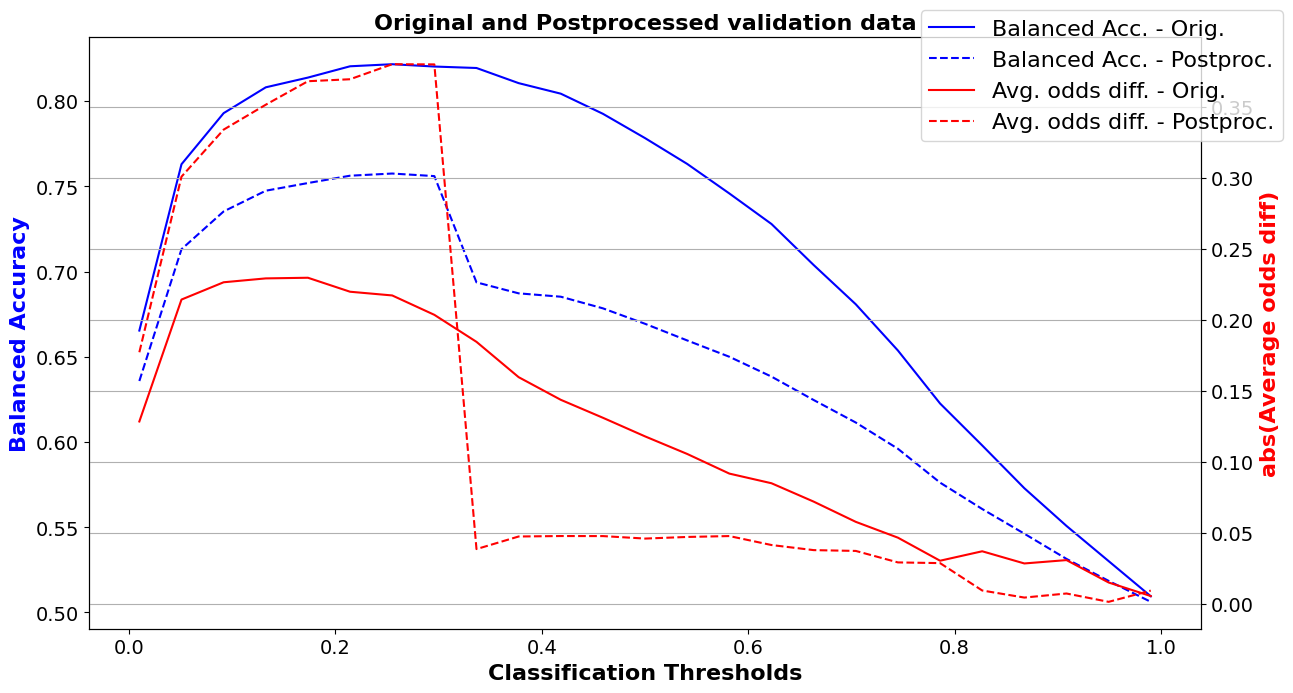

In [ ]:
all_thresh = np.linspace(0.01, 0.99, 25)

metrics = calculate_metrics_for_thresholds(valid_bld, valid_bld_pred, valid_bld_cpp_mitigated, unprivileged_groups, privileged_groups, all_thresh)
plot_metrics(metrics, all_thresh)


100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


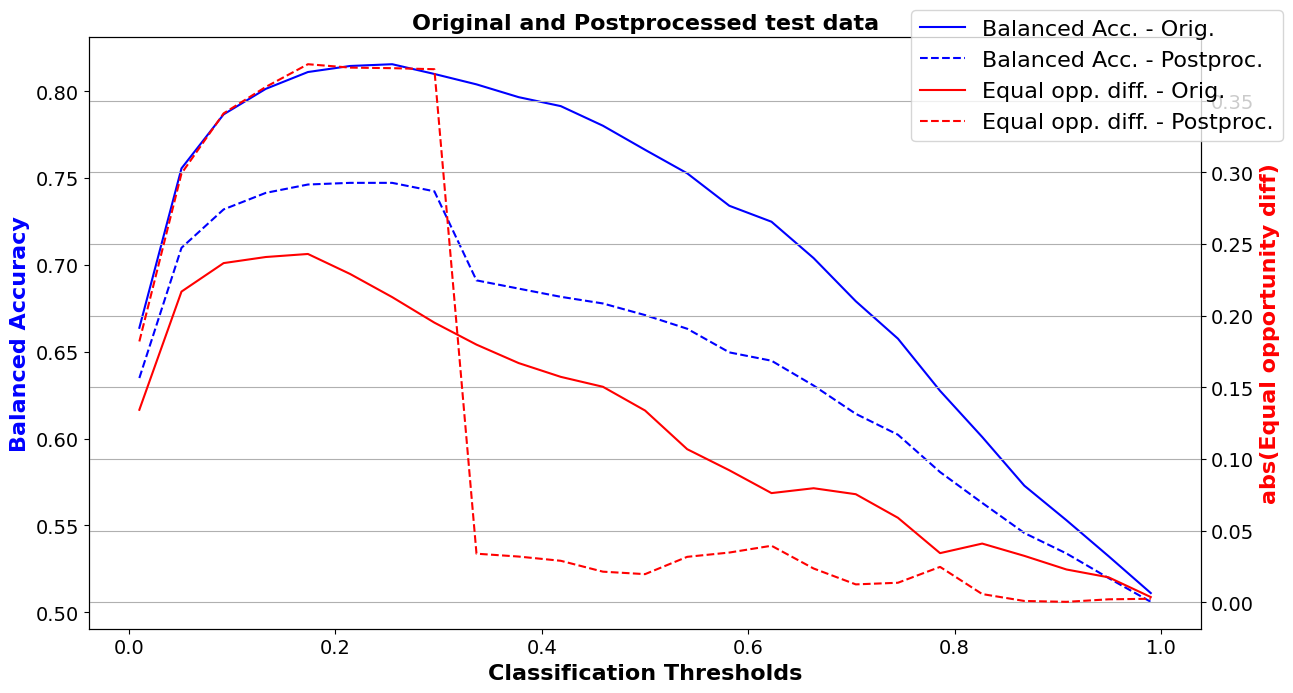

In [ ]:
test_metrics = calculate_metrics_for_thresholds(test_bld, test_bld_pred, test_bld_cpp_mitigated, unprivileged_groups, privileged_groups, all_thresh)
plot_metrics(test_metrics, all_thresh, data_name='test')